## Comparative Statistical and Machine Learning Analysis of Red Wine Quality

In [438]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "whitegrid")

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb
import mord as m
import shap 

### 1. Data Exploration and Visual Analysis

In [439]:
df = pd.read_csv("C:\\Users\\mckmo\\Downloads\\wine+quality\\winequality-red.csv", sep=";")
print("Shape:", df.shape)
print(df.isnull().sum())
# print(df.describe())
df.head() 


Shape: (1599, 12)
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


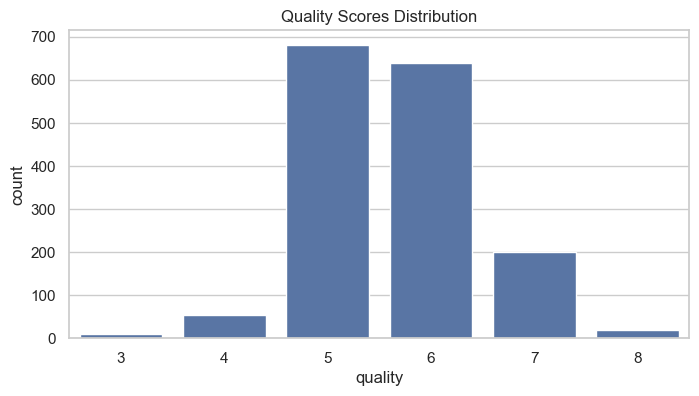

In [440]:
plt.figure(figsize = (8,4))
sns.countplot(x = "quality", data = df)
plt.title("Quality Scores Distribution")
plt.show()

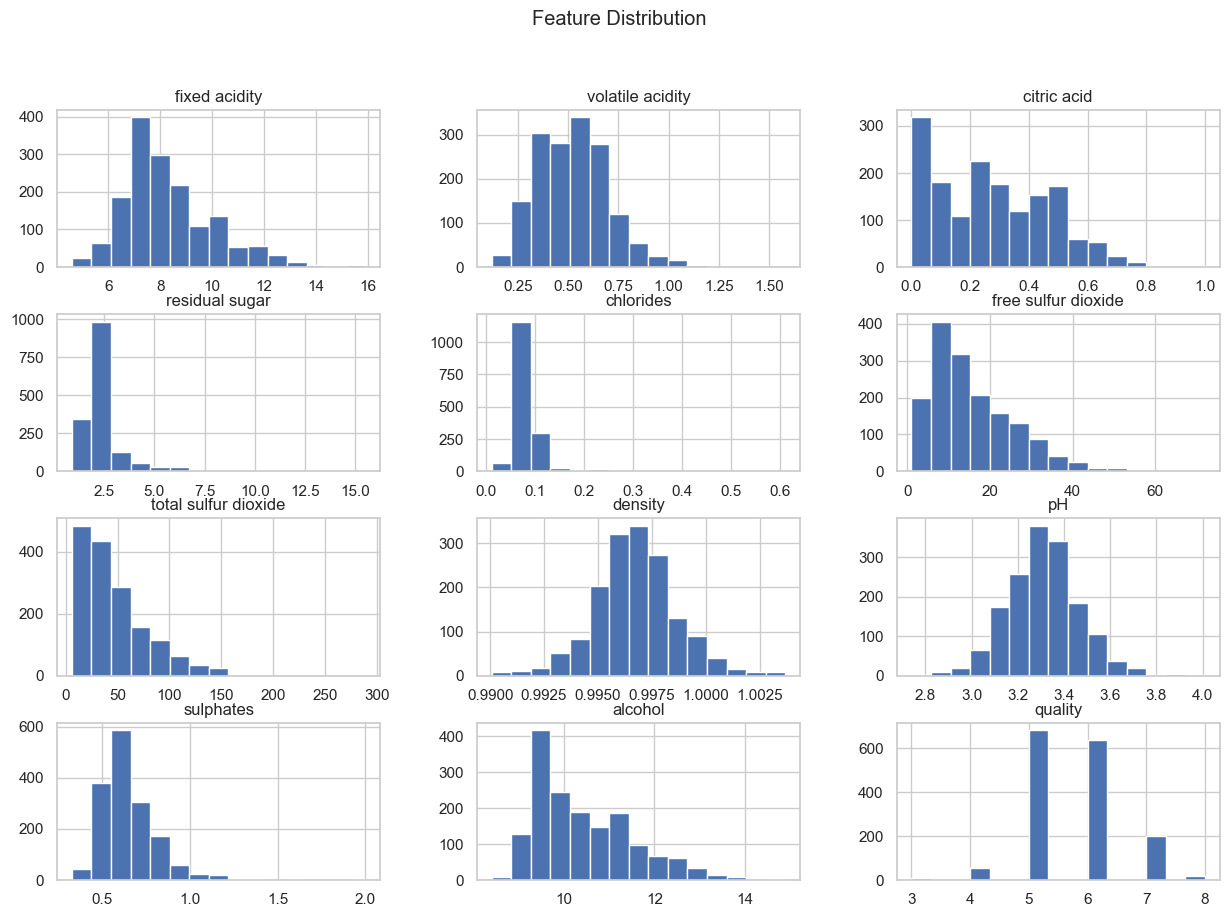

In [441]:
df.hist(bins = 15, figsize = (15,10), layout = (4,3))
plt.suptitle("Feature Distribution")
plt.show()

Note: Several features are noticeably right-skewed or contain outliers

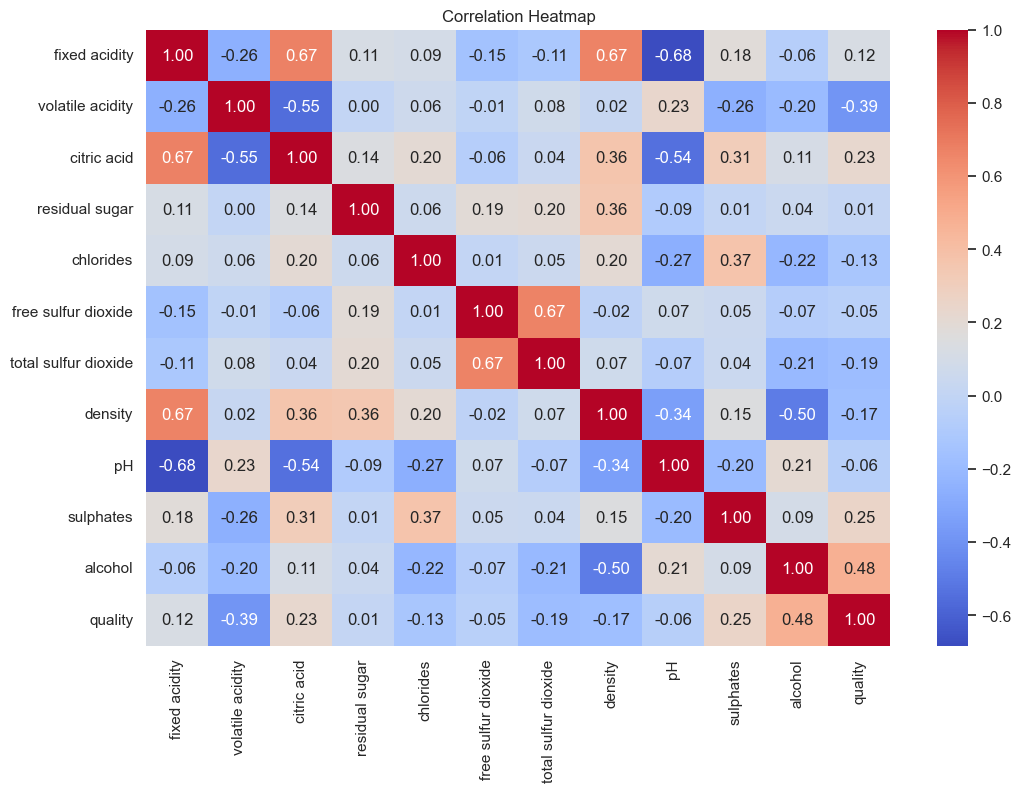

In [442]:
plt.figure(figsize = (12,8))
sns.heatmap(df.corr(), annot = True , fmt = ".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

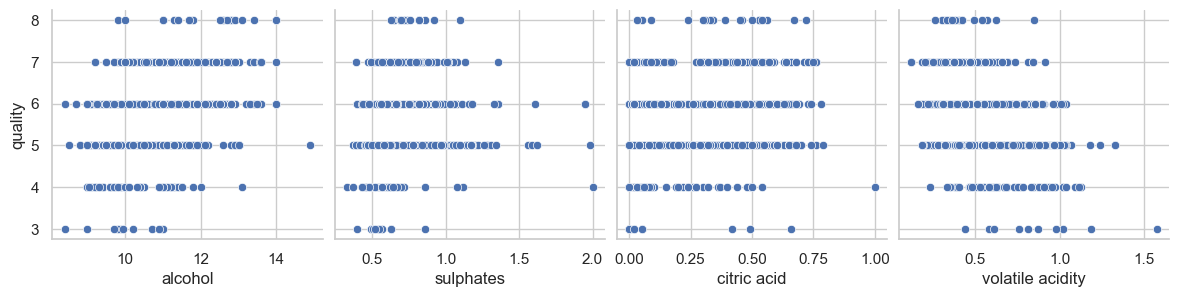

In [443]:
top_features = ["alcohol","sulphates", "citric acid", "volatile acidity"]
sns.pairplot(df, x_vars = top_features, y_vars = "quality", kind = "scatter", height = 3)
plt.show()

### 2. Statistical Diagnostics: Multicollinearity and Preprocessing

In [444]:

X = df.drop("quality", axis = 1)
y = df["quality"]


# Adding a constant (intercept) for statsmodels VIF calc
X_vif = X.copy()
X_vif['intercept'] = 1 

# Calc VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
vif_results = vif_data[vif_data["Feature"] != "intercept"].sort_values(by="VIF", ascending=False)

#print("VIF Results (Before Split):")
#print(vif_results)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify = y)

skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=123 )

### 3. Parametric Modeling: Linear and Ordinal Regression

In [445]:

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
predict = lr_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)

#print(f"Linear Regression Results:\nRMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR-squared: {r2:.3f}")

In [446]:
lr_cv_scores = cross_val_score(lr_pipeline, X, y, cv=skf, scoring = "r2")
# print("Linear Regression CV R-squared Scores:", np.round(lr_cv_scores, 3))
print("Mean R-squared:", np.round(np.mean(lr_cv_scores), 3))
# print("StDev R-squared:", np.round(np.std(lr_cv_scores), 3))

Mean R-squared: 0.348


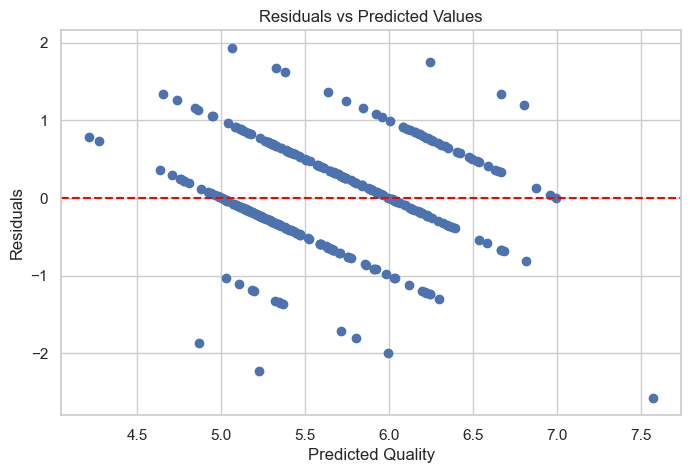

In [447]:
residuals = y_test - predict

plt.figure(figsize = (8,5))
plt.scatter(predict, residuals)
plt.axhline(0, color = 'red', linestyle = "--")
plt.xlabel("Predicted Quality")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

Note: Residuals show clear bias and heteroscedasticity. Variance increases with predicted value, which indicates model misspecification, which is consistent with a hidden non-linear relationship.

In [448]:
ord_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", m.LogisticAT(alpha=1.0))
])

ord_pipeline.fit(X_train, y_train)
ord_preds = ord_pipeline.predict(X_test)

acc_ord = accuracy_score(y_test, ord_preds)
mae_ord = mean_absolute_error(y_test, ord_preds)

#print("Ordinal Regression Results")
#print(f"Accuracy: {acc_ord:.3f}\nMAE: {mae_ord:.3f}")

In [449]:
ord_cv_scores = cross_val_score(ord_pipeline, X, y, cv=skf, scoring = "neg_mean_absolute_error")
# print("Ordinal Regression CV MAE:", np.round(-ord_cv_scores, 3))
# print("Mean MAE:", np.round(-np.mean(ord_cv_scores), 3))
# print("StDev MAE:", np.round(np.std(-ord_cv_scores), 3))
# MAE better captures ordered distance btwn predicted categories

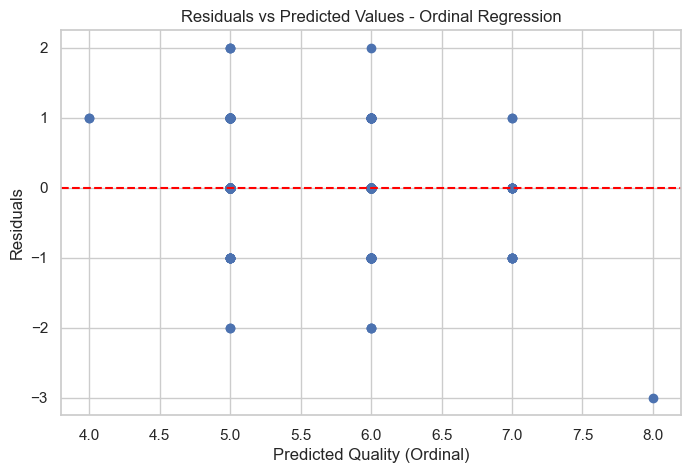

In [450]:
ord_residual = y_test - ord_preds
plt.figure(figsize=(8,5))
plt.scatter(ord_preds, ord_residual)
plt.axhline(0, color = "red", linestyle="--")
plt.xlabel("Predicted Quality (Ordinal)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values - Ordinal Regression")
plt.show()

### 4. Non-Parametric Ensemble Models: RandomForest and XGBoost

In [451]:
rf = RandomForestRegressor(random_state = 123)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
mae = mean_absolute_error(y_test, rf_preds)
r2 = r2_score(y_test, rf_preds)

print("Random Forest Results: ")
print(f"RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR-squared: {r2:.3f}\n")

#RF Cross Validation
rf_cv_scores = cross_val_score(rf, X, y, cv = skf, scoring ="r2")
# print("Random Forest CV R-squared Scores:", np.round(rf_cv_scores, 3))
#print("Mean R-squared:", np.round(np.mean(rf_cv_scores), 3))
#print("StDev R-squared:", np.round(np.std(rf_cv_scores), 3))

Random Forest Results: 
RMSE: 0.589
MAE: 0.414
R-squared: 0.462



In [452]:
# RF RandomizedSearch CV
rf_base = RandomForestRegressor(random_state = 123)

param_dist_rf = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_leaf": [1, 2, 4, 6, 8]}

rf_random = RandomizedSearchCV(
    estimator = rf_base,
    param_distributions=param_dist_rf,
    n_iter = 50,
    cv = skf,
    scoring = "r2",
    random_state = 123,
    n_jobs = -1,
    verbose = 1
)
rf_random.fit(X_train, y_train)

#print("Best RF Parameters:", rf_random.best_params_)
#print("Best RF CV R-squared:", rf_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,RandomForestR...dom_state=123)
,param_distributions,"{'max_depth': [None, 5, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [100, 200, ...]}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,123
,error_score,nan


In [453]:
# Tuned RF CV
best_rf = rf_random.best_estimator_

rf_tuned_cv_scores = cross_val_score(best_rf,
                                    X,
                                    y,
                                    cv=skf,
                                    scoring = "r2",
                                    n_jobs = 1)

#print("Tuned RF CV R² Scores:", np.round(rf_tuned_cv_scores, 3))
#print("Mean R²:", np.round(np.mean(rf_tuned_cv_scores), 3))
#print("Std R²:", np.round(np.std(rf_tuned_cv_scores), 3))

rf_base_cv_mean = np.mean(rf_cv_scores)
rf_tuned_cv_mean = np.mean(rf_tuned_cv_scores)

#print("\nRF Improvement Over Baseline:")
#print(f"Baseline CV R²: {rf_base_cv_mean:.3f}")
#print(f"Tuned CV R²:    {rf_tuned_cv_mean:.3f}")
#print(f"Improvement:    {rf_tuned_cv_mean - rf_base_cv_mean:.3f}")

In [454]:
xgb_base = xgb.XGBRegressor(
    objective = "reg:squarederror",
    random_state = 123
)
param_dist_xgb = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
}

xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=50,
    cv=skf,
    scoring="r2",
    random_state=123,
    n_jobs=-1,
    verbose=1
)

xgb_random.fit(X_train, y_train)

#print("Best XGB Parameters:", xgb_random.best_params_)
#print("Best XGB CV R²:", xgb_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [2, 3, ...], 'n_estimators': [100, 200, ...]}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,123
,error_score,nan


In [471]:
# Tuned XGB CV
best_xgb = xgb_random.best_estimator_

xgb_tuned_cv_scores = cross_val_score(
    best_xgb,
    X,
    y,
    cv=skf,
    scoring = "r2",
    n_jobs = -1
)
#print("Tuned XGB CV R-squared Scores:", np.round(xgb_tuned_cv_scores, 3))
#print("Mean R-squared:", np.round(np.mean(xgb_tuned_cv_scores), 3))
#print("StDev R-squared:", np.round(np.std(xgb_tuned_cv_scores), 3))


### 5. Feature Importance and Interpretability

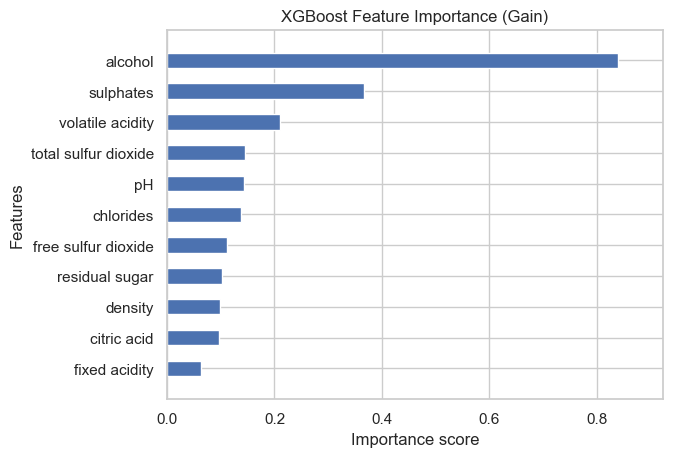

In [456]:
# XGB tuned feature importance plot
xgb.plot_importance(best_xgb, height = 0.5, importance_type = "gain", show_values = False)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

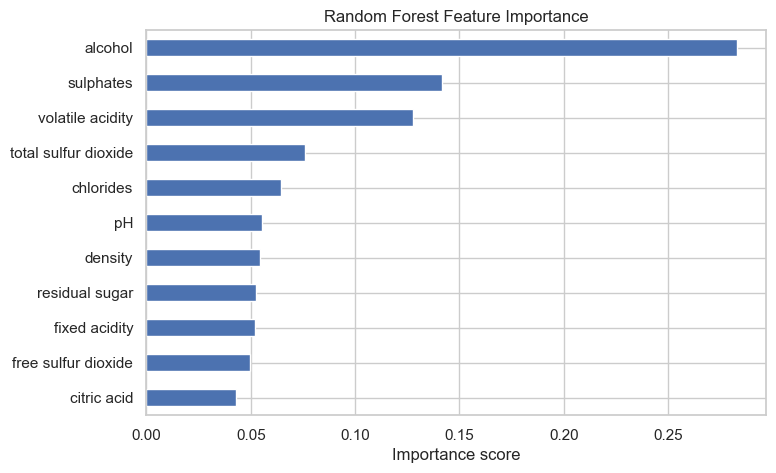

In [457]:
# Random Forest Feature Importance tuned
rf_importances = pd.Series(best_rf.feature_importances_, index = X.columns)
rf_importances.sort_values().plot(kind = "barh", figsize = (8,5))
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance score")
plt.show()

Text(0.5, 1.0, 'Random Forest SHAP Summary')

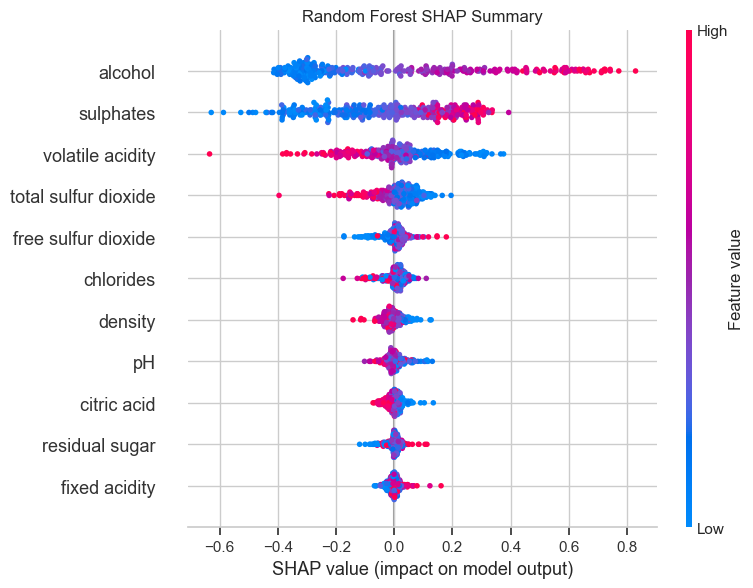

In [458]:
explain_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explain_rf.shap_values(X_test)

shap.summary_plot(shap_values_rf, X_test, show=False)
plt.title("Random Forest SHAP Summary")

Text(0.5, 1.0, 'XGBoost SHAP Summary')

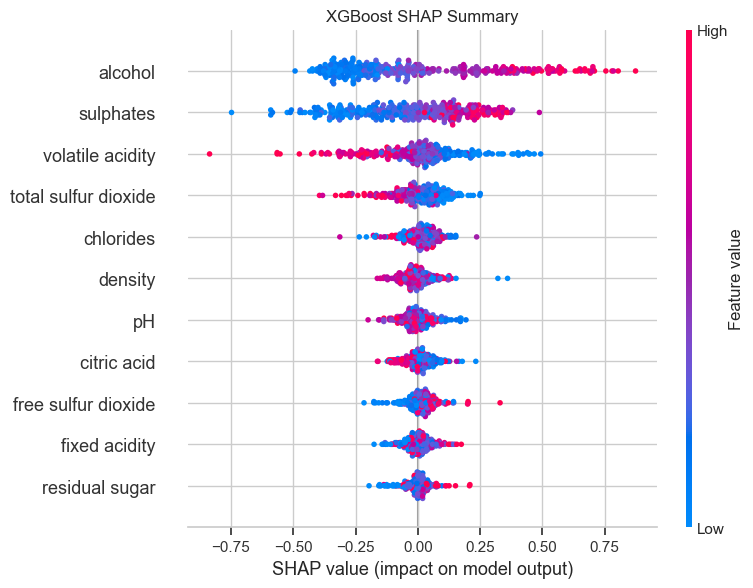

In [459]:
explain_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explain_xgb.shap_values(X_test)

shap.summary_plot(shap_values_xgb, X_test, show=False)
plt.title("XGBoost SHAP Summary")

In [460]:
# Generate final test set predictions using the tuned models
rf_tuned_preds = best_rf.predict(X_test)
xgb_tuned_preds = best_xgb.predict(X_test)

print(f"Final Tuned RF Test R²: {r2_score(y_test, rf_tuned_preds):.3f}")
print(f"Final Tuned XGB Test R²: {r2_score(y_test, xgb_tuned_preds):.3f}")

Final Tuned RF Test R²: 0.463
Final Tuned XGB Test R²: 0.441


### 6. Robustness Testing: Controlled Distribution Shift

In [461]:
median_alcohol = df["alcohol"].median()

train_shift = df[df["alcohol"] <= median_alcohol]
test_shift = df[df["alcohol"] > median_alcohol]

X_train_shift = train_shift.drop("quality", axis = 1)
y_train_shift = train_shift["quality"]

X_test_shift = test_shift.drop("quality", axis = 1)
y_test_shift = test_shift["quality"]

#print("Train Size (low alcohol):", X_train_shift.shape[0])
# print("Test Size (high alcohol):", X_test_shift.shape[0])

Mean Quality (Low Alcohol Train): 5.324
Mean Quality (High Alcohol Test): 5.983


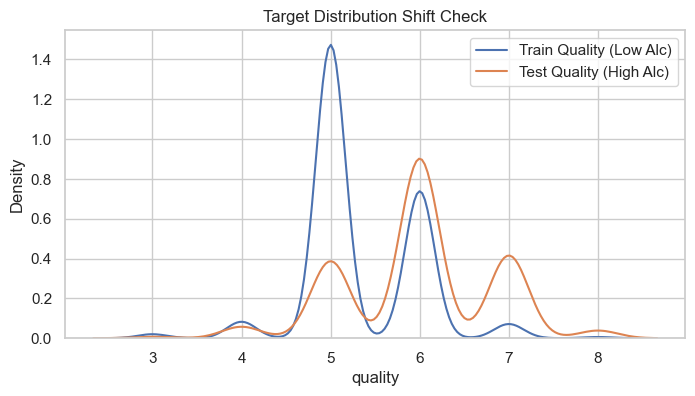

In [462]:
# Diagnostic check for target drift
print(f"Mean Quality (Low Alcohol Train): {y_train_shift.mean():.3f}")
print(f"Mean Quality (High Alcohol Test): {y_test_shift.mean():.3f}")

# Compare distributions
plt.figure(figsize=(8,4))
sns.kdeplot(y_train_shift, label="Train Quality (Low Alc)")
sns.kdeplot(y_test_shift, label="Test Quality (High Alc)")
plt.title("Target Distribution Shift Check")
plt.legend()
plt.show()

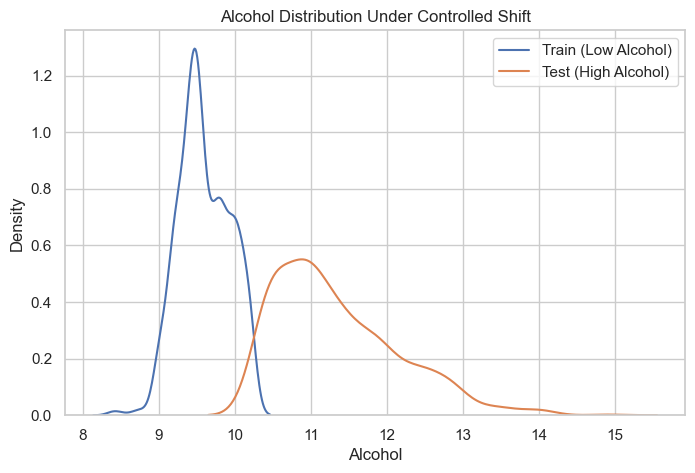

In [463]:
plt.figure(figsize=(8,5))
sns.kdeplot(train_shift["alcohol"], label="Train (Low Alcohol)")
sns.kdeplot(test_shift["alcohol"], label="Test (High Alcohol)")
plt.legend()
plt.title("Alcohol Distribution Under Controlled Shift")
plt.xlabel("Alcohol")
plt.ylabel("Density")
plt.show()

In [464]:
rf_shift = best_rf
rf_shift.fit(X_train_shift, y_train_shift)

rf_shift_preds = rf_shift.predict(X_test_shift)

rf_shift_rmse = np.sqrt(mean_squared_error(y_test_shift, rf_shift_preds))
rf_shift_mae = mean_absolute_error(y_test_shift, rf_shift_preds)
rf_shift_r2 = r2_score(y_test_shift, rf_shift_preds)

print("Random Forest under Distribution Shift")
print(f"RMSE: {rf_shift_rmse:.3f}\nMAE: {rf_shift_mae:.3f}\nR-squared: {rf_shift_r2:.3f}")

Random Forest under Distribution Shift
RMSE: 0.830
MAE: 0.673
R-squared: 0.002


In [465]:
xgb_shift = best_xgb
xgb_shift.fit(X_train_shift, y_train_shift)

xgb_shift_preds = xgb_shift.predict(X_test_shift)

xgb_shift_rmse = np.sqrt(mean_squared_error(y_test_shift, xgb_shift_preds))
xgb_shift_mae = mean_absolute_error(y_test_shift, xgb_shift_preds)
xgb_shift_r2 = r2_score(y_test_shift, xgb_shift_preds)

print("XGBoost under Distribution Shift")
print(f"RMSE: {xgb_shift_rmse:.3f}\nMAE: {xgb_shift_mae:.3f}\nR-squared: {xgb_shift_r2:.3f} ")

XGBoost under Distribution Shift
RMSE: 0.858
MAE: 0.700
R-squared: -0.066 


In [466]:
rf_original_r2 = r2_score(y_test, rf_preds)
xgb_original_r2 = r2_score(y_test, xgb_tuned_preds)

rf_degradation = rf_original_r2 - rf_shift_r2
xgb_degradation = xgb_original_r2 - xgb_shift_r2

comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "Original R-squared": [rf_original_r2, xgb_original_r2],
    "Shifted R-squared": [rf_shift_r2, xgb_shift_r2],
    "R-squared Drop": [rf_degradation, xgb_degradation],
})
comparison_df

,Model,Original R-squared,Shifted R-squared,R-squared Drop
0,Random Forest,0.462363,0.001828,0.460536
1,XGBoost,0.440651,-0.066044,0.506695


### 7. Final Model Comparison and Summary

In [467]:

summary_df = pd.DataFrame({
    "Model": ["Linear Regression", "Ordinal Regression", "Random Forest (Tuned)", "XGBoost (Tuned)"],
    
    # Test RMSE
    "Test RMSE": [
        np.round(np.sqrt(mean_squared_error(y_test, predict)), 3),
        "-",  # Ordinal is classification
        np.round(np.sqrt(mean_squared_error(y_test, rf_tuned_preds)), 3),
        np.round(np.sqrt(mean_squared_error(y_test, xgb_tuned_preds)), 3)
    ],
    
    # Test MAE
    "Test MAE": [
        np.round(mean_absolute_error(y_test, predict), 3),
        np.round(mean_absolute_error(y_test, ord_preds), 3),
        np.round(mean_absolute_error(y_test, rf_tuned_preds), 3),
        np.round(mean_absolute_error(y_test, xgb_tuned_preds), 3)
    ],
    
    # Test R²
    "Test R²": [
        np.round(r2_score(y_test, predict), 3),
        "-",  
        np.round(r2_score(y_test, rf_tuned_preds), 3),
        np.round(r2_score(y_test, xgb_tuned_preds), 3)
    ],
    
    # Cross-Validation (Tuned CV scores)
    "CV R² Mean": [
        np.round(np.mean(lr_cv_scores), 3),
        "-", 
        np.round(np.mean(rf_tuned_cv_scores), 3),
        np.round(np.mean(xgb_tuned_cv_scores), 3)
    ],
    
    "CV MAE Mean": [
        "-",
        np.round(-np.mean(ord_cv_scores), 3), 
        "-",
        "-"
    ],
    
    # Robustness (R² Drop)
    "R² Drop (Shift)": [
        "-",
        "-", 
        np.round(r2_score(y_test, rf_tuned_preds) - rf_shift_r2, 3),
        np.round(r2_score(y_test, xgb_tuned_preds) - xgb_shift_r2, 3)
    ]
})

summary_df

,Model,Test RMSE,Test MAE,Test R²,CV R² Mean,CV MAE Mean,R² Drop (Shift)
0,Linear Regression,0.671,0.517,0.303,0.348,-,-
1,Ordinal Regression,-,0.459,-,-,0.437,-
2,Random Forest (Tuned),0.589,0.412,0.463,0.5,-,0.461
3,XGBoost (Tuned),0.601,0.390,0.441,0.478,-,0.507
